

remove job feature
make function
run on 3 bias
plot some results


In [1]:
%load_ext autoreload
%autoreload 2

In [50]:
%matplotlib inline

In [ ]:
!pip install aif360
!pip install BlackBoxAuditing

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import utils.functions as f

In [78]:
dataset = "direct_matching_20240213"  # "direct_matching_20240213" or "reverse_matching_20240213"
df_processed = pd.read_csv(f"Data/{dataset}_processed.csv", sep=";")

## Gender

In [89]:
sectors = sorted(df_processed.job_sector.unique())
protected_attribute = "cand_gender"

df_mitigation = df_processed.drop(columns=["cand_id", "cand_education", "job_professional_category"]).copy()
columns = df_mitigation.columns
columns = columns.drop(["job_id","job_sector"])

results_df = f.compute_bias_differences(df_mitigation,sectors,protected_attribute,columns)
#results_df.to_excel('results_summary.xlsx', index=False)

results_df

,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Ceco,...,Spagnolo,Croato,Finlandese,Arabo,Danese,Serbo,Portoghese,Ebraico,Rumeno,Cinese
0,316.017899,22.918488,0.0,0.0,0.0,184.0,11.0,0.0,185.0,0.0,...,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1,229.424357,0.935387,0.0,0.0,0.0,106.0,22.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,607.821358,27.919029,0.0,0.0,0.0,585.0,128.0,0.0,50.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1146.527752,1.506744,0.0,0.0,0.0,223.0,180.0,0.0,85.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
4,907.004792,50.070999,0.0,0.0,0.0,953.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1347.359169,66.988174,0.0,0.0,0.0,464.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,261.838385,9.574043,0.0,0.0,0.0,484.0,159.0,0.0,180.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1429.262764,67.327622,0.0,0.0,0.0,1721.0,1260.0,0.0,412.0,1.0,...,0.0,0.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
8,509.016976,74.356888,0.0,0.0,0.0,955.0,248.0,0.0,780.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,624.899319,4.731728,0.0,0.0,0.0,346.0,85.0,0.0,0.0,0.0,...,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
sums = results_df.iloc[:, 9:].sum()
print(sums)

Ceco           1.0
Macedone       4.0
Tedesco        3.0
Persiano      16.0
Svedese        7.0
Albanese      14.0
Spagnolo       0.0
Croato         7.0
Finlandese     3.0
Arabo         21.0
Danese         1.0
Serbo          0.0
Portoghese     1.0
Ebraico        0.0
Rumeno         0.0
Cinese         3.0
dtype: float64


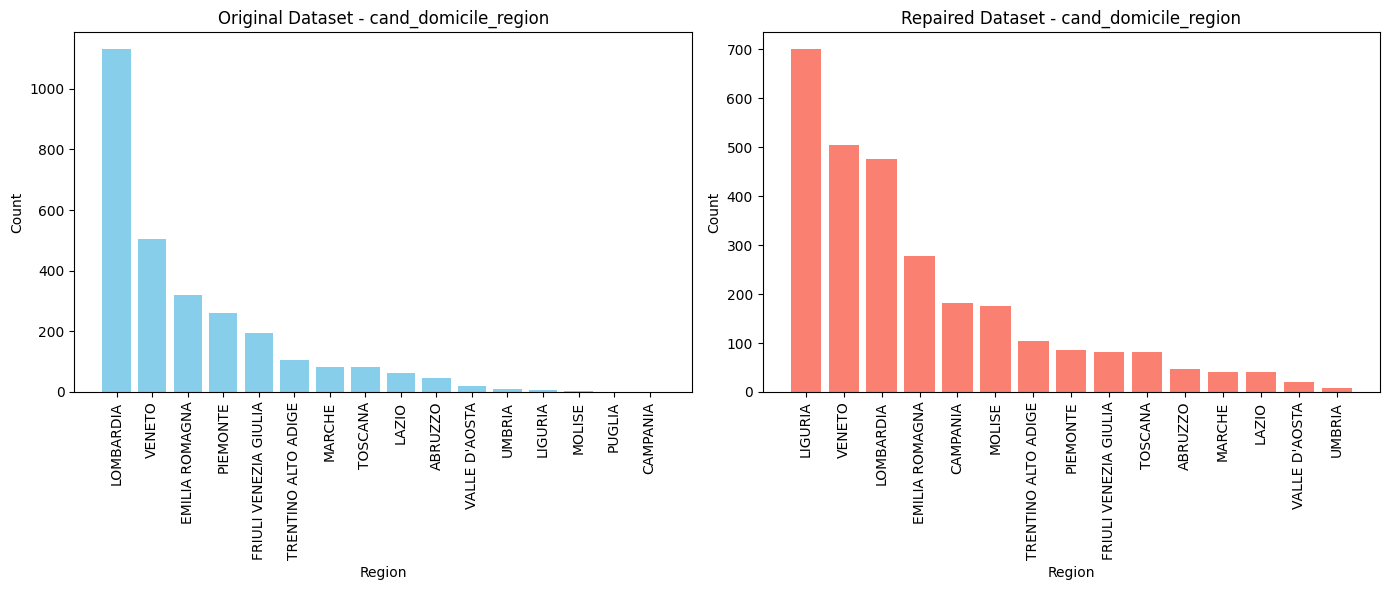

In [56]:
with open('Encodings/direct_matching_20240213_cand_domicile_region_encoding.json', 'r') as file:
    region_mapping = json.load(file)

# Reverse the mapping: string to integer
reversed_region_mapping = {v: k for k, v in region_mapping.items()}

job_df_orig, job_df_repaired = f.compute_repaired_df(df_mitigation,7,protected_attribute)

job_df_orig['cand_domicile_region_str'] = job_df_orig['cand_domicile_region'].map(reversed_region_mapping)
job_df_repaired['cand_domicile_region_str'] = job_df_repaired['cand_domicile_region'].map(reversed_region_mapping)

# Define the feature to compare
feature = 'cand_domicile_region_str'

# Calculate value counts
orig_counts = job_df_orig[feature].value_counts()
repaired_counts = job_df_repaired[feature].value_counts()

# Create plots
plt.figure(figsize=(14, 6))

# Plot value counts for the original dataset
plt.subplot(1, 2, 1)
plt.bar(orig_counts.index, orig_counts.values, color='skyblue')
plt.title('Original Dataset - cand_domicile_region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Plot value counts for the repaired dataset
plt.subplot(1, 2, 2)
plt.bar(repaired_counts.index, repaired_counts.values, color='salmon')
plt.title('Repaired Dataset - cand_domicile_region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [57]:
print("Value counts for 'Arabo' in job_df_orig:")
print(job_df_orig['Arabo'].value_counts())

print("\nValue counts for 'Arabo' in job_df_repaired:")
print(job_df_repaired['Arabo'].value_counts())

Value counts for 'Arabo' in job_df_orig:
Arabo
0.0    2817
1.0      10
Name: count, dtype: int64

Value counts for 'Arabo' in job_df_repaired:
Arabo
0.0    2827
Name: count, dtype: int64


## Age

In [90]:
protected_attribute = "cand_age_bucket"

results_df = f.compute_bias_differences(df_mitigation,sectors,protected_attribute,columns)
results_df

,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Ceco,...,Spagnolo,Croato,Finlandese,Arabo,Danese,Serbo,Portoghese,Ebraico,Rumeno,Cinese
0,304.399663,7.395134,0.0,0.0,0.0,335.0,73.0,0.0,-68.0,0.0,...,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1,228.615830,-2.070259,66.0,0.0,0.0,356.0,11.0,0.0,-220.0,0.0,...,5.0,2.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
2,-91.183931,-8.566383,47.0,0.0,0.0,15.0,548.0,0.0,1986.0,0.0,...,0.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-465.383827,0.557617,40.0,0.0,0.0,70.0,185.0,0.0,444.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
4,291.609679,46.502220,81.0,0.0,0.0,402.0,856.0,0.0,404.0,0.0,...,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
5,37.250072,0.791176,0.0,0.0,0.0,253.0,440.0,0.0,850.0,0.0,...,0.0,8.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
6,137.898669,-9.060768,22.0,0.0,0.0,189.0,264.0,0.0,171.0,0.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,14.0,0.0,0.0
7,-301.192693,-35.694054,0.0,0.0,0.0,403.0,537.0,0.0,-117.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,164.006248,-3.043098,0.0,0.0,0.0,134.0,175.0,0.0,485.0,0.0,...,28.0,0.0,1.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0
9,-9.197868,6.826012,46.0,0.0,0.0,66.0,342.0,0.0,823.0,0.0,...,11.0,4.0,0.0,1.0,0.0,0.0,0.0,16.0,43.0,0.0


In [81]:
columns

Index(['distance_km', 'match_score', 'match_rank', 'cand_gender',
       'cand_age_bucket', 'cand_domicile_province', 'cand_domicile_region',
       'job_contract_type', 'job_work_province', 'Ceco', 'Macedone', 'Tedesco',
       'Persiano', 'Svedese', 'Albanese', 'Spagnolo', 'Croato', 'Finlandese',
       'Arabo', 'Danese', 'Serbo', 'Portoghese', 'Ebraico', 'Rumeno',
       'Cinese'],
      dtype='object')

In [88]:
protected_attribute = "same_location"

results_df = f.compute_bias_differences(df_mitigation,sectors,protected_attribute,columns)
results_df

,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,job_contract_type,job_work_province,Ceco,...,Croato,Finlandese,Arabo,Danese,Serbo,Portoghese,Ebraico,Rumeno,Cinese,same_location
0,7859.605473,17.784119,0.0,0.0,0.0,1440.0,427.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2587.806569,1.985207,0.0,0.0,0.0,231.0,247.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6467.913466,10.770035,0.0,0.0,0.0,2249.0,34.0,0.0,56.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6169.671333,5.900627,0.0,0.0,0.0,611.0,349.0,0.0,297.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
4,6472.513154,28.117096,0.0,0.0,0.0,1214.0,918.0,0.0,1149.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,15849.094067,60.437744,0.0,0.0,0.0,3772.0,33.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4502.474936,8.895142,0.0,0.0,0.0,510.0,305.0,0.0,360.0,0.0,...,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22050.899386,126.559105,0.0,0.0,0.0,2880.0,1800.0,0.0,1195.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,10099.362573,24.148232,0.0,0.0,0.0,1825.0,310.0,0.0,776.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,5246.018154,7.922150,0.0,0.0,0.0,864.0,354.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
